# Removing dark space around the skull

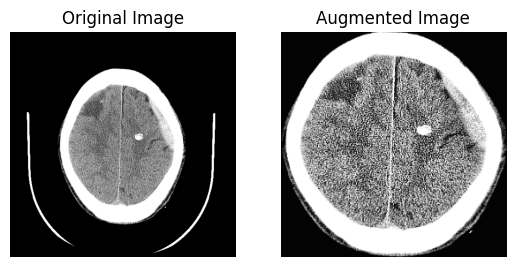

In [1]:
import cv2
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt

def crop_brain(image, threshold=10):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply a binary threshold only
    _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    
    # Find the contours of the binary image
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get the bounding box of the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Crop the image using the bounding box coordinates
    crop = image[y:y+h, x:x+w]
    
    return crop

# Define the custom Albumentations transform
class BrainCrop(A.ImageOnlyTransform):
    def __init__(self, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        
    def apply(self, image, **params):
        return crop_brain(image)

class CLAHE(A.ImageOnlyTransform):
    def __init__(self, clip_limit=2.0, tile_grid_size=(8,8), always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        
    def apply(self, image, **params):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
        img_clahe = clahe.apply(gray)
        img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2BGR)
        return img_clahe

# Define the transform pipeline
transform = A.Compose([
    BrainCrop(),
    A.Resize(256, 256),  # Resize the cropped image
    CLAHE()  # Apply CLAHE filter
])

# Load an image
image = cv2.imread("hemorrhage\\CQ500CT13_slice_20.png")

# Apply the transforms
augmented_image = transform(image=image)["image"]

# Display the images
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Augmented Image")
plt.imshow(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()



# Applying CLAHE mask

In [3]:
import os
import shutil

def process_images(input_dir, output_dir, transform):
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Get a list of all image filenames in the input directory
    image_filenames = os.listdir(input_dir)

    # Process each image
    for filename in image_filenames:
        # Ignore non-image files
        if not (filename.endswith(".png") or filename.endswith(".jpg")):
            continue

        # Read the image
        image = cv2.imread(os.path.join(input_dir, filename))

        # Apply the transforms
        try:
            augmented_image = transform(image=image)["image"]
        except Exception as e:
            print(f"Error processing image {filename}: {e}")
            continue

        # Save the preprocessed image to the output directory
        cv2.imwrite(os.path.join(output_dir, filename), augmented_image)

# Define the transform pipeline
transform = A.Compose([
    BrainCrop(),
    A.Resize(256, 256),  # Resize the cropped image
    CLAHE()  # Apply CLAHE filter
])

# Process the images in the 'Hemorrhage' and 'Normal' folders
process_images("Hemorrhage", "Processed_Hemorrhage", transform)
process_images("Normal", "Processed_Normal", transform)
